# Eigenfaces Analysis on RGB Images using Channel-wise PCA

This notebook demonstrates how to perform **Principal Component Analysis (PCA)** on a dataset of color images to derive the **Eigenfaces** (or Eigenimages). Unlike standard PCA on grayscale images, this approach applies PCA separately to the Red, Green, and Blue channels before combining the resulting principal components for visualization.

## 1. Setup and Configuration

In [ ]:
import numpy as np
import glob
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

# --- Configuration ---
# Update this path to your image directory. The repo structure assumes 'data/'.
IMAGE_PATH = 'data/*.jpg'  # Path to the image dataset
RESIZE_DIM = (64, 64)  # Image size (width, height)
N_COMPONENTS = 50      # Number of principal components to keep for analysis/reconstruction
N_EIGENFACES_TO_PLOT = 10 # Number of Eigenfaces to visualize

## 2. Data Loading and Preprocessing

Images are loaded, resized, and flattened. The RGB channels are then separated to prepare for independent PCA.

In [13]:
def load_and_preprocess_images(path, dim):
    """Loads, resizes images, and separates the RGB channels."""
    try:
        # Load and resize all images (using a standard path placeholder)
        image_files = glob.glob(path)
        if not image_files:
             raise FileNotFoundError(f"No images found at the path: {path}. Check your data setup.")
            
        input_images = [Image.open(file).convert('RGB').resize(dim, Image.Resampling.BILINEAR) for file in image_files]
        
        # Convert images to a NumPy array
        # The shape will be (N_images, 64, 64, 3)
        input_images_array = np.array([np.asarray(i) for i in input_images])
        
        # Flatten each image into a feature vector per channel (64*64 = 4096 features)
        # Shape: (N_images, Pixels, Channels) -> (N_images, 4096, 3)
        n_images, h, w, c = input_images_array.shape
        flat_images = input_images_array.reshape(n_images, h * w, c)
        
        # Separate channels: each matrix is (N_images, 4096)
        red_channel_data = flat_images[:, :, 0].astype(np.float64)
        green_channel_data = flat_images[:, :, 1].astype(np.float64)
        blue_channel_data = flat_images[:, :, 2].astype(np.float64)
        
        print(f"Loaded {n_images} images. Reshaped channel data to: (N_images, {h*w}).")
        return red_channel_data, green_channel_data, blue_channel_data, input_images_array
        
    except FileNotFoundError as e:
        print(f"ERROR: {e}")
        print("Please ensure you have created the `data/images/` directory and populated it with images.")
        return None, None, None, None

R_data, G_data, B_data, original_images = load_and_preprocess_images(IMAGE_PATH, RESIZE_DIM)

# Exit if data loading failed
if R_data is None:
    import sys; sys.exit()

Loaded 5239 images. Reshaped channel data to: (N_images, 4096).


## 3. Channel-wise PCA and Eigenface Calculation

We use `sklearn.decomposition.PCA` for a robust implementation of PCA on each color channel independently. The principal components (eigenvectors) of the covariance matrix, when reshaped, form the Eigenfaces.

In [14]:
def perform_channel_pca(data, n_components):
    """Fits PCA on the channel data and returns the model, components, and mean."""
    # Note: PCA in sklearn automatically centers the data
    pca = PCA(n_components=n_components)
    pca.fit(data)
    
    # components_ is the Eigenvector matrix (N_components, N_features)
    # The transpose is often referred to as the Eigenfaces/Eigenvectors
    return pca, pca.components_, pca.mean_

# Run PCA for each channel
pca_r, components_r, mean_r = perform_channel_pca(R_data, N_COMPONENTS)
pca_g, components_g, mean_g = perform_channel_pca(G_data, N_COMPONENTS)
pca_b, components_b, mean_b = perform_channel_pca(B_data, N_COMPONENTS)

print("PCA completed for all three channels.")

PCA completed for all three channels.


## 4. Explained Variance Analysis

The explained variance ratio shows how much information (variance) is captured by each principal component. We check the cumulative variance captured by the top components.

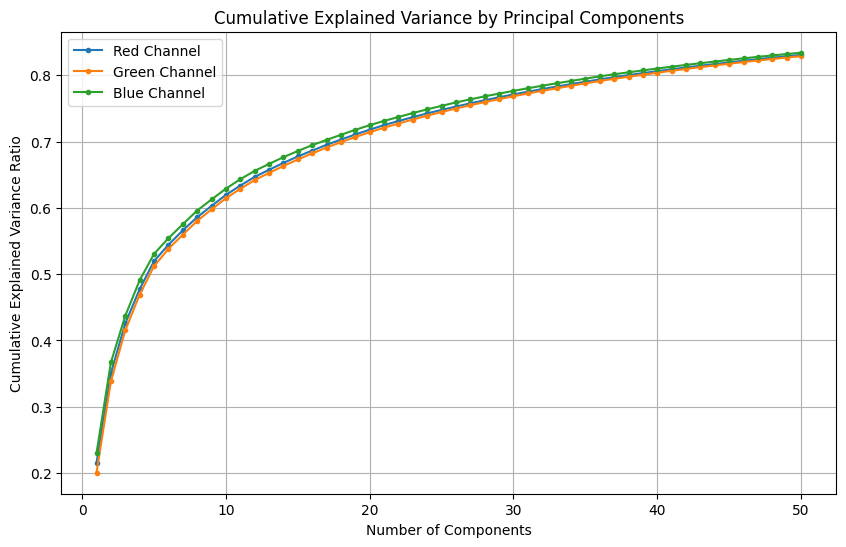

Total Variance Captured by 50 Components:
  Red Channel: 83.08%
  Green Channel: 82.89%
  Blue Channel: 83.40%


In [15]:
def plot_explained_variance(pca_r, pca_g, pca_b):
    """Plots the cumulative explained variance for all channels."""
    plt.figure(figsize=(10, 6))
    
    # Calculate cumulative variance
    cum_r = np.cumsum(pca_r.explained_variance_ratio_)
    cum_g = np.cumsum(pca_g.explained_variance_ratio_)
    cum_b = np.cumsum(pca_b.explained_variance_ratio_)
    
    plt.plot(range(1, N_COMPONENTS + 1), cum_r, label='Red Channel', marker='.')
    plt.plot(range(1, N_COMPONENTS + 1), cum_g, label='Green Channel', marker='.')
    plt.plot(range(1, N_COMPONENTS + 1), cum_b, label='Blue Channel', marker='.')
    
    plt.title('Cumulative Explained Variance by Principal Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.grid(True)
    plt.legend()
    plt.show()
    
plot_explained_variance(pca_r, pca_g, pca_b)

# Report total variance captured by N_COMPONENTS
print(f"Total Variance Captured by {N_COMPONENTS} Components:")
print(f"  Red Channel: {np.cumsum(pca_r.explained_variance_ratio_)[-1]*100:.2f}%")
print(f"  Green Channel: {np.cumsum(pca_g.explained_variance_ratio_)[-1]*100:.2f}%")
print(f"  Blue Channel: {np.cumsum(pca_b.explained_variance_ratio_)[-1]*100:.2f}%")

## 5. Visualization of Color Eigenfaces

The Eigenfaces are the principal components (eigenvectors) reshaped back into the original image dimensions. To visualize a color Eigenface, we stack the corresponding principal components from the R, G, and B channels.

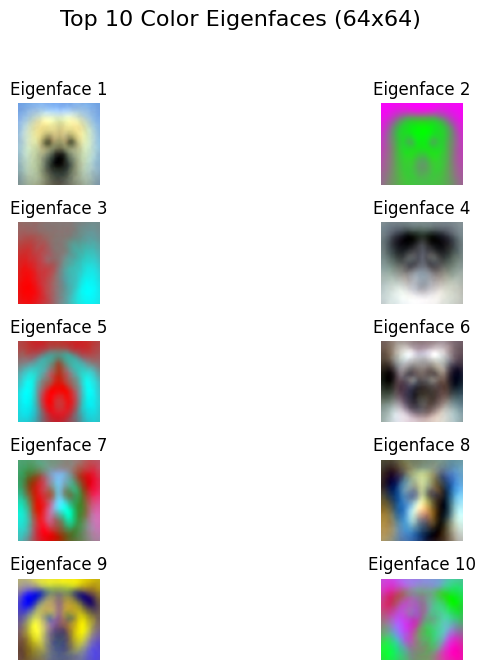

In [16]:
def normalize_and_reshape(component):
    """Normalizes a flattened component vector to 0-1 and reshapes to (64, 64)."""
    # Reshape the component (4096,) back to (64, 64)
    eigenface = component.reshape(RESIZE_DIM)
    # Normalize between 0 and 1 for display
    eigenface = (eigenface - eigenface.min()) / (eigenface.max() - eigenface.min())
    return eigenface

plt.figure(figsize=(10, N_EIGENFACES_TO_PLOT * 0.7))
plt.suptitle(f'Top {N_EIGENFACES_TO_PLOT} Color Eigenfaces ({RESIZE_DIM[0]}x{RESIZE_DIM[1]})', fontsize=16)

for i in range(N_EIGENFACES_TO_PLOT):
    # 1. Get the i-th component from each channel
    r_comp = components_r[i]
    g_comp = components_g[i]
    b_comp = components_b[i]
    
    # 2. Normalize and reshape each channel component
    r_eigenface = normalize_and_reshape(r_comp)
    g_eigenface = normalize_and_reshape(g_comp)
    b_eigenface = normalize_and_reshape(b_comp)
    
    # 3. Stack the channels to create a color image (64, 64, 3)
    color_eigenface = np.stack((r_eigenface, g_eigenface, b_eigenface), axis=-1)
    
    # 4. Plot
    ax = plt.subplot(N_EIGENFACES_TO_PLOT // 2, 2, i + 1)
    ax.imshow(color_eigenface)
    ax.set_title(f'Eigenface {i+1}')
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 6. Image Reconstruction

Finally, we demonstrate the utility of Eigenfaces by compressing and reconstructing an image using only the top $k$ principal components. The closeness of the reconstructed image to the original shows how much information is captured by the reduced basis.

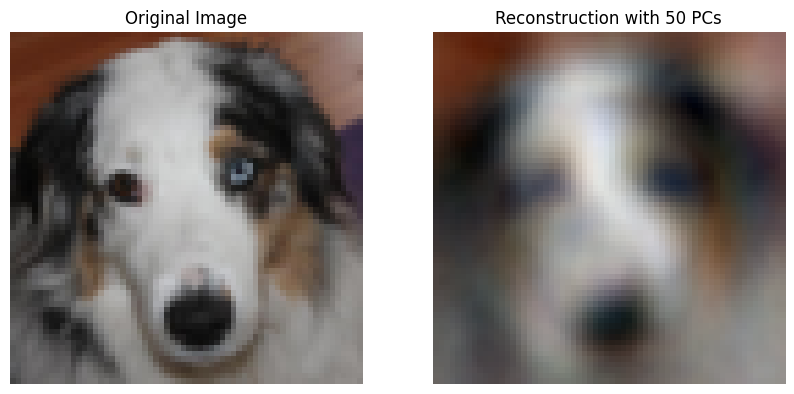

In [17]:
def reconstruct_image(data, pca_model, mean_vector, original_image_index=0):
    """Projects an image onto the PCA subspace and reconstructs it."""
    # Select the target image (flattened channel data)
    target_data = data[original_image_index:original_image_index+1]
    
    # 1. Project the data onto the Eigenface subspace (Compression)
    # This gives the weight vector (N_images, N_components)
    weights = pca_model.transform(target_data)
    
    # 2. Reconstruct the image from the weights (Decompression)
    # pca_model.inverse_transform automatically adds the mean back
    reconstructed_data = pca_model.inverse_transform(weights)
    
    # 3. Reshape back to image format (64, 64)
    reconstructed_image = reconstructed_data.reshape(RESIZE_DIM)
    
    # Ensure pixel values are within the valid 0-255 range for display
    reconstructed_image = np.clip(reconstructed_image, 0, 255).astype(np.uint8)
    
    return reconstructed_image

IMAGE_TO_TEST = 0 # Index of the image to reconstruct

# Perform reconstruction for all three channels
reconstructed_r = reconstruct_image(R_data, pca_r, mean_r, IMAGE_TO_TEST)
reconstructed_g = reconstruct_image(G_data, pca_g, mean_g, IMAGE_TO_TEST)
reconstructed_b = reconstruct_image(B_data, pca_b, mean_b, IMAGE_TO_TEST)

# Stack the results to get the final color image
reconstructed_color_image = np.stack((reconstructed_r, reconstructed_g, reconstructed_b), axis=-1)
original_color_image = original_images[IMAGE_TO_TEST]

# Plotting the comparison
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_color_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_color_image)
plt.title(f'Reconstruction with {N_COMPONENTS} PCs')
plt.axis('off')

plt.show()